<h4>Identifying Individuals Based Off Of Their Accelerometer Data Using The WISDM Data Set</h4>


In [1]:
import numpy as np
import pandas as pd

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

# save this for making a new data set if need be
# load in data set
df = pd.read_csv('WISDM_at_v2.0_raw.txt', header = None, names = columns)

# get rid of unnecessary characters
df['z-axis'] = df['z-axis'].str.rstrip(';')

# obtain only walking data since this has the most of any activity
walking = df.loc[df.activity == 'Walking']

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# unique id's before getting rid of those without a sufficient amount of data
walking.user.unique()

array([1679,  599,  685,  669, 1277,  674,  594,  678,  648,  584,  582,
        636, 1758,  708,  711,  687,  563,  621,  623,  720, 1793,  568,
        640,  671,  694,  664,  585,  684, 1480,  655, 1603,  651,  579,
        613,  590,  639,  587,  719,  635, 1742,  624,  710,  676,  693,
        646,  713,  610,  615,  705,  653,  702,  604,  618,  654,  656,
        606,  998,  586, 1319,  668, 1768, 1100,  573, 1491,  712, 1518,
        730,  622,  647, 1727, 1477,  588,  634,  661,  686,  690,  709,
        663,  597, 1656,  630,  616,  691,  625,  612,  650,  658, 1750,
        598,  729,  714,  607,  628,  589,  728,  925,  593,  600,  637,
        641,  609,  633, 1783,  688,  605, 1247,  695,  595,  602,  194,
        583,  716,  727, 1797, 1320, 1676,  673, 1802,  611, 1117,  689,
       1774,  666,  617,  706,  627,  675, 1799, 1703,  670, 1759, 1554,
       1778, 1064, 1238,  726,  632,  608,  725,  614,  697, 1775,  592,
        723,  591, 1512, 1253,  580,  703,  722,  6

In [4]:
# obtain only users who have over x minutes of data
minDataPoints = 16000

for i in walking.user.unique():    
    if len(walking[walking.user == i]) < minDataPoints: 
        walking = walking[walking.user != i]

In [5]:
# Unique users after stripping those who don't have enough data points
print(walking.user.unique())
print(len(walking.user.unique()))

[ 669  648  585 1750  641  688  602  675 1238  608  603  679]
12


In [6]:
# get rid of unnecessary characters and rows with empty entries
walking = walking[walking.columns.unique()].replace(';', '')
walking = walking.dropna()

# update columns to be usable types
walking.timestamp = walking.timestamp.astype(int)
walking['x-axis'] = walking['x-axis'].astype(float)
walking['y-axis'] = walking['y-axis'].astype(float)
walking['z-axis'] = walking['z-axis'].astype(float)


In [7]:
# function to normalize time stamps starting at 0 milliseconds
def normalize_time_stamps(df):

    # iterate through all users
    for user in df.user.unique():

        # iterate through all activities
        for activity in df.activity.unique():

            key = (df.user == user) & (df.activity == activity)
            # obtain all rows for a particular user and an activity
            user_activity_to_process = df[key]
            
            # if there are no rows for this activity, drop the activity from that user
            if len(user_activity_to_process.timestamp) == 0:
                df[(df.user == user)] = df[(df.user == user) & (df.activity != activity)]
                break

            # otherwise normalize the time stamps to start at 0, and be in milliseconds?
            else:
                df.loc[key, 'timestamp'] -= user_activity_to_process.timestamp.iloc[0]
                df.loc[key, 'timestamp'] /= 1000
                print(df[key])
                            
    return df

In [8]:
# obtain a data set with normalized time stamps
# this doesn't really matter for actual training, but it's nice to have clean timestamps
walking_norm = normalize_time_stamps(walking)
for user in walking_norm.user.unique():
    print(walking_norm.loc[walking_norm.user == user, 'timestamp'])

       user activity  timestamp  x-axis  y-axis  z-axis
39169   669  Walking       0.00    6.09    3.99   -0.04
39170   669  Walking       0.05    6.36    3.68   -0.27
39171   669  Walking       0.10    7.63    4.63   -0.42
39172   669  Walking       0.15    7.63    5.71   -0.53
39173   669  Walking       0.20    9.04    6.47    0.08
...     ...      ...        ...     ...     ...     ...
58557   669  Walking     716.60    4.14   11.03    1.12
58558   669  Walking     716.60    4.14   11.03    1.12
58559   669  Walking     716.60    4.14   11.03    1.12
58560   669  Walking     716.60    4.14   11.03    1.12
58561   669  Walking     716.60    4.14   11.03    1.12

[16532 rows x 6 columns]
        user activity  timestamp  x-axis  y-axis     z-axis
112345   648  Walking       0.00   -2.11    6.47   5.284695
112346   648  Walking       0.05   -4.25    8.12  10.569390
112347   648  Walking       0.10    3.15    2.07   5.434519
112348   648  Walking       0.15   -0.61    4.60   5.325556
11

In [9]:
from sklearn.preprocessing import StandardScaler

# scale x,y,z axes
scaler = StandardScaler()
walking_norm[['x-axis', 'y-axis', 'z-axis']] = scaler.fit_transform(walking_norm[['x-axis', 'y-axis', 'z-axis']].to_numpy())

In [10]:
# utilize 2 second windows with 50% overlap 
new_features = []
labels = []

# 20 HZ sampling means 20 samples every second. Therefore 2 seconds is 40 samples, .
step_size = 20
window_size = 40

for user in walking_norm.user.unique():
    user_walking_data = walking_norm[walking_norm.user == user]

    # go through each users walking data and transform it into 
    for window_start in range(0, len(user_walking_data) - window_size, step_size):
        x = user_walking_data['x-axis'].values[window_start: window_start + window_size]
        y = user_walking_data['y-axis'].values[window_start: window_start + window_size]
        z = user_walking_data['z-axis'].values[window_start: window_start + window_size]
        new_features.append([x, y, z])

        # label for a data window is just the user
        labels.append(user)

# Convert to numpy
new_features = np.asarray(new_features, dtype=np.float32).transpose(0, 2, 1)

In [11]:
# perform preprocessing 
from scipy.signal import find_peaks, peak_widths
from numpy import linalg as LA


def preprocess_xyz(features, labels):
    
    # array to hold new vector
    processed_features = []
    
    # columns for each new feature that's derived from x,y,z accelerometer data
    new_columns = ['bias',
               'x_mean', 'y_mean', 'z_mean', 
               'x_median', 'y_median', 'z_median', 
               'magnitude',
               'xz_cor', 'yz_cor',
               'x_peaks', 'y_peaks', 'z_peaks', 'avg_peaks',
               'x_peak_width_mean', 'y_peak_width_mean', 'z_peak_width_mean',
               'x_avg_dist_from_mean', 'y_avg_dist_from_mean', 'z_avg_dist_from_mean',
               'x_fft_mean', 'y_fft_mean', 'z_fft_mean', 
               'x_fft_median', 'y_fft_median', 'z_fft_median', 
              ]
    for row in features:
        
        # obtain x,y,z axes data for particular window
        x = row[:,0]
        y = row[:,1]
        z = row[:,2]
        
        x_fft = np.fft.fft(x)
        y_fft = np.fft.fft(y)
        z_fft = np.fft.fft(z)


        # find the peaks of height greater than 0.1 for x,y,z axes
        x_peaks, _ = find_peaks(x, height=0.1)
        y_peaks, _ = find_peaks(y, height=0.1)
        z_peaks, _ = find_peaks(z, height=0.1)
        
        # obtain average width of peaks from base for x,y,z axes
        x_peak_widths = peak_widths(x, x_peaks, rel_height=0)
        y_peak_widths = peak_widths(y, y_peaks, rel_height=0)
        z_peak_widths = peak_widths(z, z_peaks, rel_height=0)
        
        # average distance from mean
        
        x_avg_dist = np.mean(x-np.mean(x))
        y_avg_dist = np.mean(y-np.mean(y))
        z_avg_dist = np.mean(z-np.mean(z))
        
        # 16 time domain features per row 
        # we may want to include these same features for the frequency domain
        new_row = [1,
                   np.average(x), np.average(y), np.average(z),
                   np.median(x),  np.median(y),  np.median(z),
                   LA.norm(row),
                   np.average(x)/np.average(z), np.average(y)/np.average(z),
                   len(x_peaks), len(y_peaks), len(z_peaks), len(x_peaks)+len(y_peaks)+len(z_peaks)/3,
                   np.average(x_peak_widths), np.average(y_peak_widths), np.average(z_peak_widths),
                   x_avg_dist, y_avg_dist, z_avg_dist,
                   np.abs(np.average(x_fft)), np.abs(np.average(y_fft)), np.abs(np.average(z_fft)),
                   np.abs(np.median(x_fft)),  np.abs(np.median(y_fft)),  np.abs(np.median(z_fft)),
                   ]
        
        # append the new feature row to the data set
        processed_features.append(new_row)

        
    # create dataframe so we can see what's going on in the data
    processed_data = pd.DataFrame(processed_features, columns=new_columns)

    # scale all features again
    scaler = StandardScaler()
    processed_data[new_columns[1:]] = scaler.fit_transform(processed_data[new_columns[1:]])
    
    # append column of users
    processed_data['user'] = labels
    
    return processed_data


In [12]:
# process our data
feature_vector = preprocess_xyz(new_features, labels)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
# this shows that there are some data points that are homogenous where no movement took
# place within the two seconds. Maybe widening the window makes sense then? If not ...
feature_vector = feature_vector.dropna(axis='rows')

In [14]:
# preview dataframe
feature_vector

,bias,x_mean,y_mean,z_mean,x_median,y_median,z_median,magnitude,xz_cor,yz_cor,...,x_avg_dist_from_mean,y_avg_dist_from_mean,z_avg_dist_from_mean,x_fft_mean,y_fft_mean,z_fft_mean,x_fft_median,y_fft_median,z_fft_median,user
0,1,1.867056,0.255785,0.025818,1.949569,0.179617,-0.022780,0.320794,0.059359,0.047701,...,3.216208,0.301481,-0.003169,0.309675,-1.294781,-0.855070,1.152995,-0.165760,-0.742386,669
1,1,1.754642,0.260062,0.028687,1.612877,0.197183,-0.061361,0.118414,0.051619,0.044000,...,2.572708,0.338775,0.079358,-0.819744,-1.270934,-0.373547,-0.267782,-0.346353,-0.197355,669
2,1,1.751326,0.321477,0.077204,1.649050,0.238820,-0.015765,0.055154,0.025089,0.022761,...,1.929207,0.749008,-0.333275,1.095358,-0.091012,0.160837,0.080677,1.172485,0.058826,669
3,1,2.041287,0.302116,0.097898,1.918961,0.236868,-0.061361,0.455021,0.023828,0.018168,...,2.787208,-0.686808,0.161884,3.299315,-1.294781,1.284946,-0.116474,0.111492,1.591690,669
4,1,1.806227,0.256014,0.129373,1.715832,0.149040,-0.061361,0.230895,0.019159,0.013466,...,1.071206,-0.546956,0.161884,-0.540254,-1.147431,-0.613998,0.223829,-0.145300,-0.330353,669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12915,1,-1.997639,0.779100,0.322225,-1.844482,0.916074,0.170125,1.083619,0.005563,0.015304,...,-3.218798,0.152305,-0.333275,4.315383,0.636702,3.115381,1.067233,0.407787,1.327751,679
12917,1,-1.724543,0.668057,-0.182424,-1.759613,0.660396,-0.291094,0.465447,0.016072,-0.010293,...,4.610460,0.637126,-0.333275,0.921348,-0.733224,-0.003853,-0.370107,-0.175450,-0.636971,679
12918,1,-1.689400,0.612879,-0.150079,-1.492485,0.558255,-0.131509,0.360874,0.017276,-0.012054,...,0.642206,-0.071458,-0.168222,-0.130081,-1.066776,-0.100033,-0.758004,-0.061622,-0.350658,679
12919,1,-1.736187,0.672791,0.013297,-1.868134,0.716996,0.064904,0.409035,-0.081642,0.227138,...,0.266830,-1.227570,-0.168222,-0.031871,-0.958474,-0.475738,-0.517267,-0.096461,-0.101437,679


In [15]:
# how many users are left after drop NA
len(feature_vector['user'].unique())

12

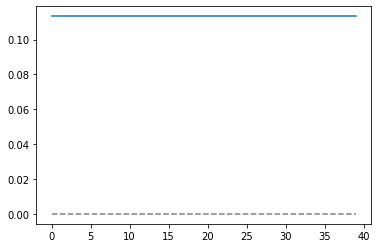

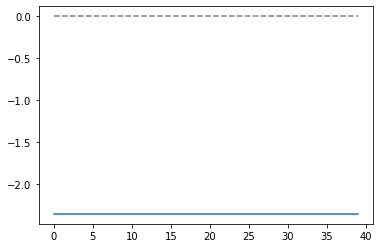

In [26]:
# get idea of what data looks like
import matplotlib.pyplot as plt
row = new_features[-100]
x = row[:,0]
peaks, _ = find_peaks(x, height=0.0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

row = new_features[1500]
x = row[:,0]
peaks, _ = find_peaks(x, height=0.0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [17]:
''' 
Then it's clear that there are some useless data points in this set because 
there is no movement. So we'll get rid of it.
'''
useful_feature_vector = feature_vector[feature_vector['avg_peaks'] != 0]

# max number of dropped windows, 20%
max_users = 10
cuttoff = minDataPoints//40
cuttoff -= cuttoff//10 * 2

# num users before pruning
print("users before pruning: " + str(len(useful_feature_vector.user.unique())))

# pruning after windowing
unique_users = useful_feature_vector.user.unique()

for i in unique_users:
    # if there are less features than the cutoff, then get rid of that user
    if len(useful_feature_vector[useful_feature_vector.user == i]) < cuttoff: 
        useful_feature_vector = useful_feature_vector[useful_feature_vector.user != i]
    else:
        # otherwise let's get rid of the excess features
        useful_feature_vector = useful_feature_vector.drop(useful_feature_vector[useful_feature_vector.user == i][cuttoff:].index)
    
        
unique_users = useful_feature_vector.user.unique()

for i in range(0, len(unique_users)):
    # if there are more than the max users, get rid of them
    if i > max_users - 1:
        useful_feature_vector = useful_feature_vector[useful_feature_vector.user != unique_users[i]]
print("users after pruning: " + str(len(useful_feature_vector.user.unique())))

    

# now our training set and labels are ready to be used
X = useful_feature_vector.drop(columns=['user']).to_numpy()
y = useful_feature_vector['user'].to_numpy()

users before pruning: 12
users after pruning: 10


<h4>Prepare Models</h4>

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# foud work around for sklearn on medium
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def print_metrics(y_test, preds, model_name):
    cm = pd.crosstab(y_test, preds, rownames=['Actual User'], colnames=['Predicted User'])
    plt.figure(figsize = (11,7))
    sn.heatmap(cm, annot=True, fmt='g')
    
    recall = recall_score(y_test, preds, average='macro')
    
    print("TOTAL " + model_name + " RECALL: ", recall)
    
    auc = multiclass_roc_auc_score(y_test, preds)
    print("TOTAL " + model_name + " AUC: ", auc)
    
    accuracy = accuracy_score(y_test, preds)
    print("TOTAL " + model_name + " ACCURACY: ", accuracy)
    print("---------------------- classification report ----------------------")
    classes = np.unique(y_test)
    classes = list(map(str, classes.tolist()))
    cr = classification_report(y_test, preds, target_names=classes)
    print(cr)

In [19]:
# first let's try a RF (Random Forest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def random_forest(X_train, y_train, X_test, y_test, metrics=False):
    classifier = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=10)
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    if metrics:
        print_metrics(y_test, preds, "Random Forest")
        
    return accuracy

In [20]:
# try a decision tree

from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, y_train, X_test, y_test, metrics=False):

    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    if metrics:
        print_metrics(y_test, preds, "Decision Tree")
        
    return accuracy


In [21]:
from sklearn import svm

def support_vector_machine(X_train, y_train, X_test, y_test, metrics=False):
    classifier = svm.SVC(gamma='auto')
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    if metrics:
        print_metrics(y_test, preds, "Support Vector Machine")

    return accuracy



In [22]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(X_train, y_train, X_test, y_test, metrics=False):
    classifier = LogisticRegression(random_state=0, 
                                    solver='newton-cg',
                                    multi_class='auto',
                                    max_iter=1200).fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    if metrics:
        print_metrics(y_test, preds, "Linear Regression")
        
    return accuracy


In [23]:
# prepare training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
              X, y, test_size=0.3, random_state=42, stratify=y)

TOTAL Random Forest RECALL:  0.9604166666666666
TOTAL Random Forest AUC:  0.9780092592592593
TOTAL Random Forest ACCURACY:  0.9604166666666667
---------------------- classification report ----------------------
              precision    recall  f1-score   support

         585       0.95      0.99      0.97        96
         602       0.94      0.99      0.96        96
         603       0.99      0.92      0.95        96
         608       0.96      0.99      0.97        96
         641       0.90      0.93      0.91        96
         648       0.96      0.93      0.94        96
         669       0.99      0.95      0.97        96
         675       1.00      1.00      1.00        96
         688       0.98      1.00      0.99        96
        1750       0.95      0.92      0.93        96

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960



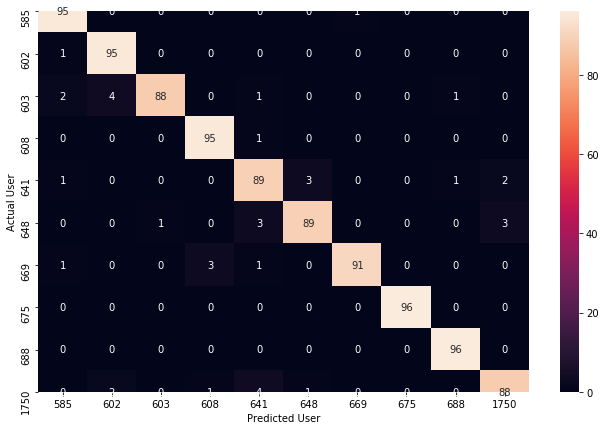

In [24]:
# run a particular model with the test set
rf = random_forest(X_train, y_train, X_test, y_test, True)
#decision_tree(X_train, y_train, X_test, y_test, True)
#support_vector_machine(X_train, y_train, X_test, y_test, True)
#logistic_regression(X_train, y_train, X_test, y_test, True)

<b>K-Fold Cross Validation</b>

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

number_of_splits = max_users
total_accuracy = 0

# perform kfold cross validation
kf = StratifiedKFold(n_splits=number_of_splits, random_state=None, shuffle=True)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train model
    
    # random forest
    accuracy = random_forest(X_train, y_train, X_test, y_test)
    
    # decision tree
    #accuracy = decision_tree(X_train, y_train, X_test, y_test)
    
    # svm
    #accuracy = support_vector_machine(X_train, y_train, X_test, y_test)
    
    # logistic regression
    #accuracy = logistic_regression(X_train, y_train, X_test, y_test)



    
    print("Accuracy: " + str(accuracy))
    total_accuracy += accuracy
    
print("Accuracy after kfold cross validation is: " + str(total_accuracy/number_of_splits))

Accuracy: 0.96875
Accuracy: 0.978125
Accuracy: 0.978125
Accuracy: 0.9625
Accuracy: 0.9625
Accuracy: 0.971875
Accuracy: 0.975
Accuracy: 0.9625
Accuracy: 0.96875
Accuracy: 0.959375
Accuracy after kfold cross validation is: 0.9687499999999998
